# Creating the Chronos class

There should be a few specs for this method:

* Should have a scikit-learn like interface (fit, predict)
* Should have support for MLE, MAP, MCMC, and SVI
* Parameters should be easy to grab
* Should support arbitrary error distributions
* Should support censored data

In [3]:
import torch
import pyro

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import pyro
import pyro.distributions as dist

# We will use Markov Chain Monte Carlo (MCMC) methods here, specifically the No U-Turn Sampler (NUTS)
from pyro.infer import MCMC, NUTS

In [6]:
my_ts_data = pd.read_csv('data/prophetData.csv')
my_ts_data['ds'] = pd.to_datetime(my_ts_data['ds'])
my_ts_data.head()

,ds,y
0,2007-12-10,9.590761
1,2007-12-11,8.519590
2,2007-12-12,8.183677
3,2007-12-13,8.072467
4,2007-12-14,7.893572


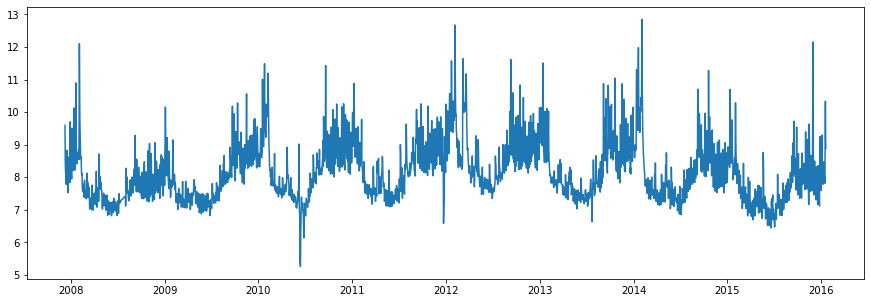

In [10]:
plt.figure(figsize=(15,5))
plt.plot(my_ts_data['ds'], my_ts_data['y'])
plt.show()

In [476]:
import torch
import pyro

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import pyro
import pyro.distributions as dist

# We will use Markov Chain Monte Carlo (MCMC) methods here, specifically the No U-Turn Sampler (NUTS)
from pyro.infer import MCMC, NUTS
from pyro.infer import SVI, Trace_ELBO

from torch.distributions import constraints

import warnings
import logging

pyro.enable_validation(True)

torch.set_default_tensor_type(torch.FloatTensor)
class Chronos:
    
    
    def __init__(self, method="MLE", n_iter=1000):
        self.method_ = method
        self.n_iter_ = n_iter
        
        
    def fit(self, data):
        ts = torch.tensor(data['ds'].values.astype(np.float32))
        y = torch.tensor(data['y'].values)
        
        
        if (self.method_ == "MLE"):
            print("Employing Maximum Likelihood Estimation")
            self.train_point_estimate(self.model_MLE, 
                                      self.guide_MLE, 
                                      ts,
                                      y)
        elif (self.method_ == "MAP"):
            print("Employing Maximum A Postiori")
            self.train_point_estimate(self.model_MAP, 
                                      self.guide_MAP, 
                                      ts,
                                      y)
        elif (self.method == "MCMC"):
            print("Employing Markov Chain Monte Carlo")
        
            
            
    ##################################################################
    def train_MCMC(self, model, ts, y, sample_num = 3000):
        pass
    
    ##################################################################
    def train_point_estimate(self, model, guide, ts, y, lr=0.1):
        
        pyro.clear_param_store()
        
        adam = pyro.optim.Adam({"lr": lr})
        
        self.svi = SVI(model, guide, adam, loss=Trace_ELBO())
        
        
        print_interval = min(self.n_iter_//10, 10000)
        for step in range(self.n_iter_):
            
            loss = self.svi.step(ts, y)/y.shape[0]
            
            if (step % print_interval == 0):
                print(f"{step} - loss: {loss}")
        print(f"{step} - loss: {loss}")
            
    ##################################################################
    
    def model_MLE(self, ts, y):
        beta_0 = pyro.param("beta_0", torch.tensor(0.0))
        beta_1 = pyro.param("beta_1", torch.tensor(0.0))
        
        sigma = pyro.param("sigma", torch.tensor(1.0), 
                           constraint = constraints.positive)
    
        mu = beta_0 + (beta_1 * ts)        
        with pyro.plate("data", y.size(0)):
            pyro.sample("obs", dist.Normal(mu, sigma), obs=y)
        
        
    
    def guide_MLE(self, ts, y):
        pass
    
    
    ##################################################################
    
    def model_MAP(self, ts, y):
        beta_0 = pyro.sample("beta_0", dist.Normal(torch.tensor(0.0), 
                                                   torch.tensor(1.0)))
        beta_1 = pyro.sample("beta_1", dist.Normal(torch.tensor(0.0), 
                                                   torch.tensor(1.0)))
        
        sigma = pyro.sample("sigma", 
                            dist.HalfCauchy(torch.tensor(1.0)))
    
        mu = beta_0 + (beta_1 * ts)
        
        with pyro.plate("data", y.size(0)):
            pyro.sample("obs", dist.Normal(mu, sigma), obs=y)
    
    def guide_MAP(self, ts, y):
        
        beta_0_val = pyro.param("beta_0_val", torch.tensor(0.0))
        pyro.sample("beta_0", dist.Delta(beta_0_val))
        
        beta_1_val = pyro.param("beta_1_val", torch.tensor(0.0))
        beta_1 = pyro.sample("beta_1", dist.Delta(beta_1_val))
        
        sigma_val = pyro.param("sigma_val", torch.tensor(10.0), 
                               constraint = constraints.positive)
        
        
        pyro.sample("sigma", dist.Delta(sigma_val))
        
    
    ##################################################################
    
    @property
    def intercept_(self):
        if (self.method_ == "MLE"):
            return pyro.param("beta_0").item()
        elif (self.method_ == "MAP"):
            return pyro.param("beta_0_val").item()

    @property
    def coef_(self):
        if (self.method_ == "MLE"):
            return pyro.param("beta_1").item()
        elif (self.method_ == "MAP"):
            return pyro.param("beta_1_val").item()
    
    

In [477]:
my_chronos = Chronos(method="MAP", n_iter=1000)
my_chronos.fit(my_ts_data)

Employing Maximum A Postiori
0 - loss: 17211705470.927906
100 - loss: 1.0780954928576896e+32
200 - loss: 1.0780954928576896e+32
300 - loss: 1.0780954928576896e+32
400 - loss: 1.0780954928576896e+32
500 - loss: 1.0780954928576896e+32
600 - loss: 1.0780954928576896e+32
700 - loss: 1.0780954928576896e+32
800 - loss: 1.0780954928576896e+32
900 - loss: 1.0780954928576896e+32
999 - loss: 1.0780954928576896e+32


In [478]:
my_chronos.intercept_

-99.89816284179688

In [479]:
my_chronos.coef_

0.10000000149011612

In [480]:
ts = my_ts_data['ds'].values.astype(np.float64)
line = ts * my_chronos.coef_ + my_chronos.intercept_

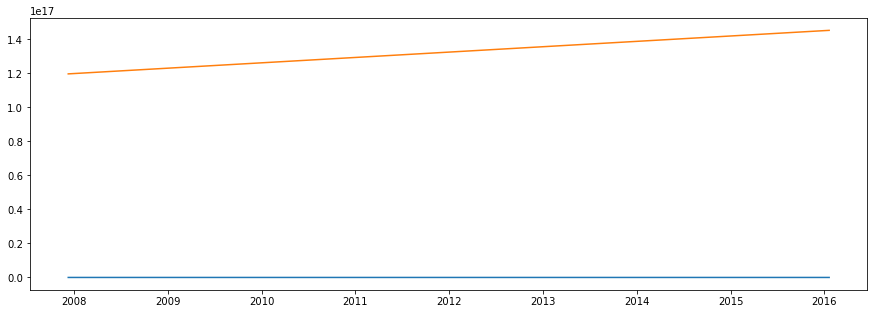

In [481]:
plt.figure(figsize=(15,5))
plt.plot(my_ts_data['ds'], my_ts_data['y'])
plt.plot(my_ts_data['ds'], line)
plt.show()

In [49]:
pyro.param("beta_0")

tensor(2.6569, requires_grad=True)